In [37]:
import pandas as pd
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt

from Bio import SeqIO
from Bio.SeqUtils import GC

sns.set_theme()
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [115]:
def event_func(path):
    file_list = glob.glob((path+'/*_eventCounts.txt'))
    events_frame = pd.DataFrame({'S':[], 'SL':[], 'D':[], 'T':[], 'TL':[], 'L':[], 'Leaf':[], 'Name':[]})
    for file_name in file_list:
        events_frame_og = pd.read_table(file_name, sep=':', header=None, index_col=0).transpose()
        name = os.path.basename(file_name); name = name.split('_')[0]
        events_frame_og['Name'] = [name]
        events_frame = events_frame.append(events_frame_og)
    events_frame.reset_index(drop=True, inplace=True)
    events_frame['AT'] = events_frame['T'] + events_frame['TL']
    return events_frame

In [116]:
events_frame = event_func("Results/geneRaxResults/reconciliations")

In [49]:
ortho = pd.read_table('Results/Orthogroups.GeneCount.tsv', sep = '\t')

In [57]:
ortho.Total.sum()

486609

<AxesSubplot:xlabel='Total', ylabel='Count'>

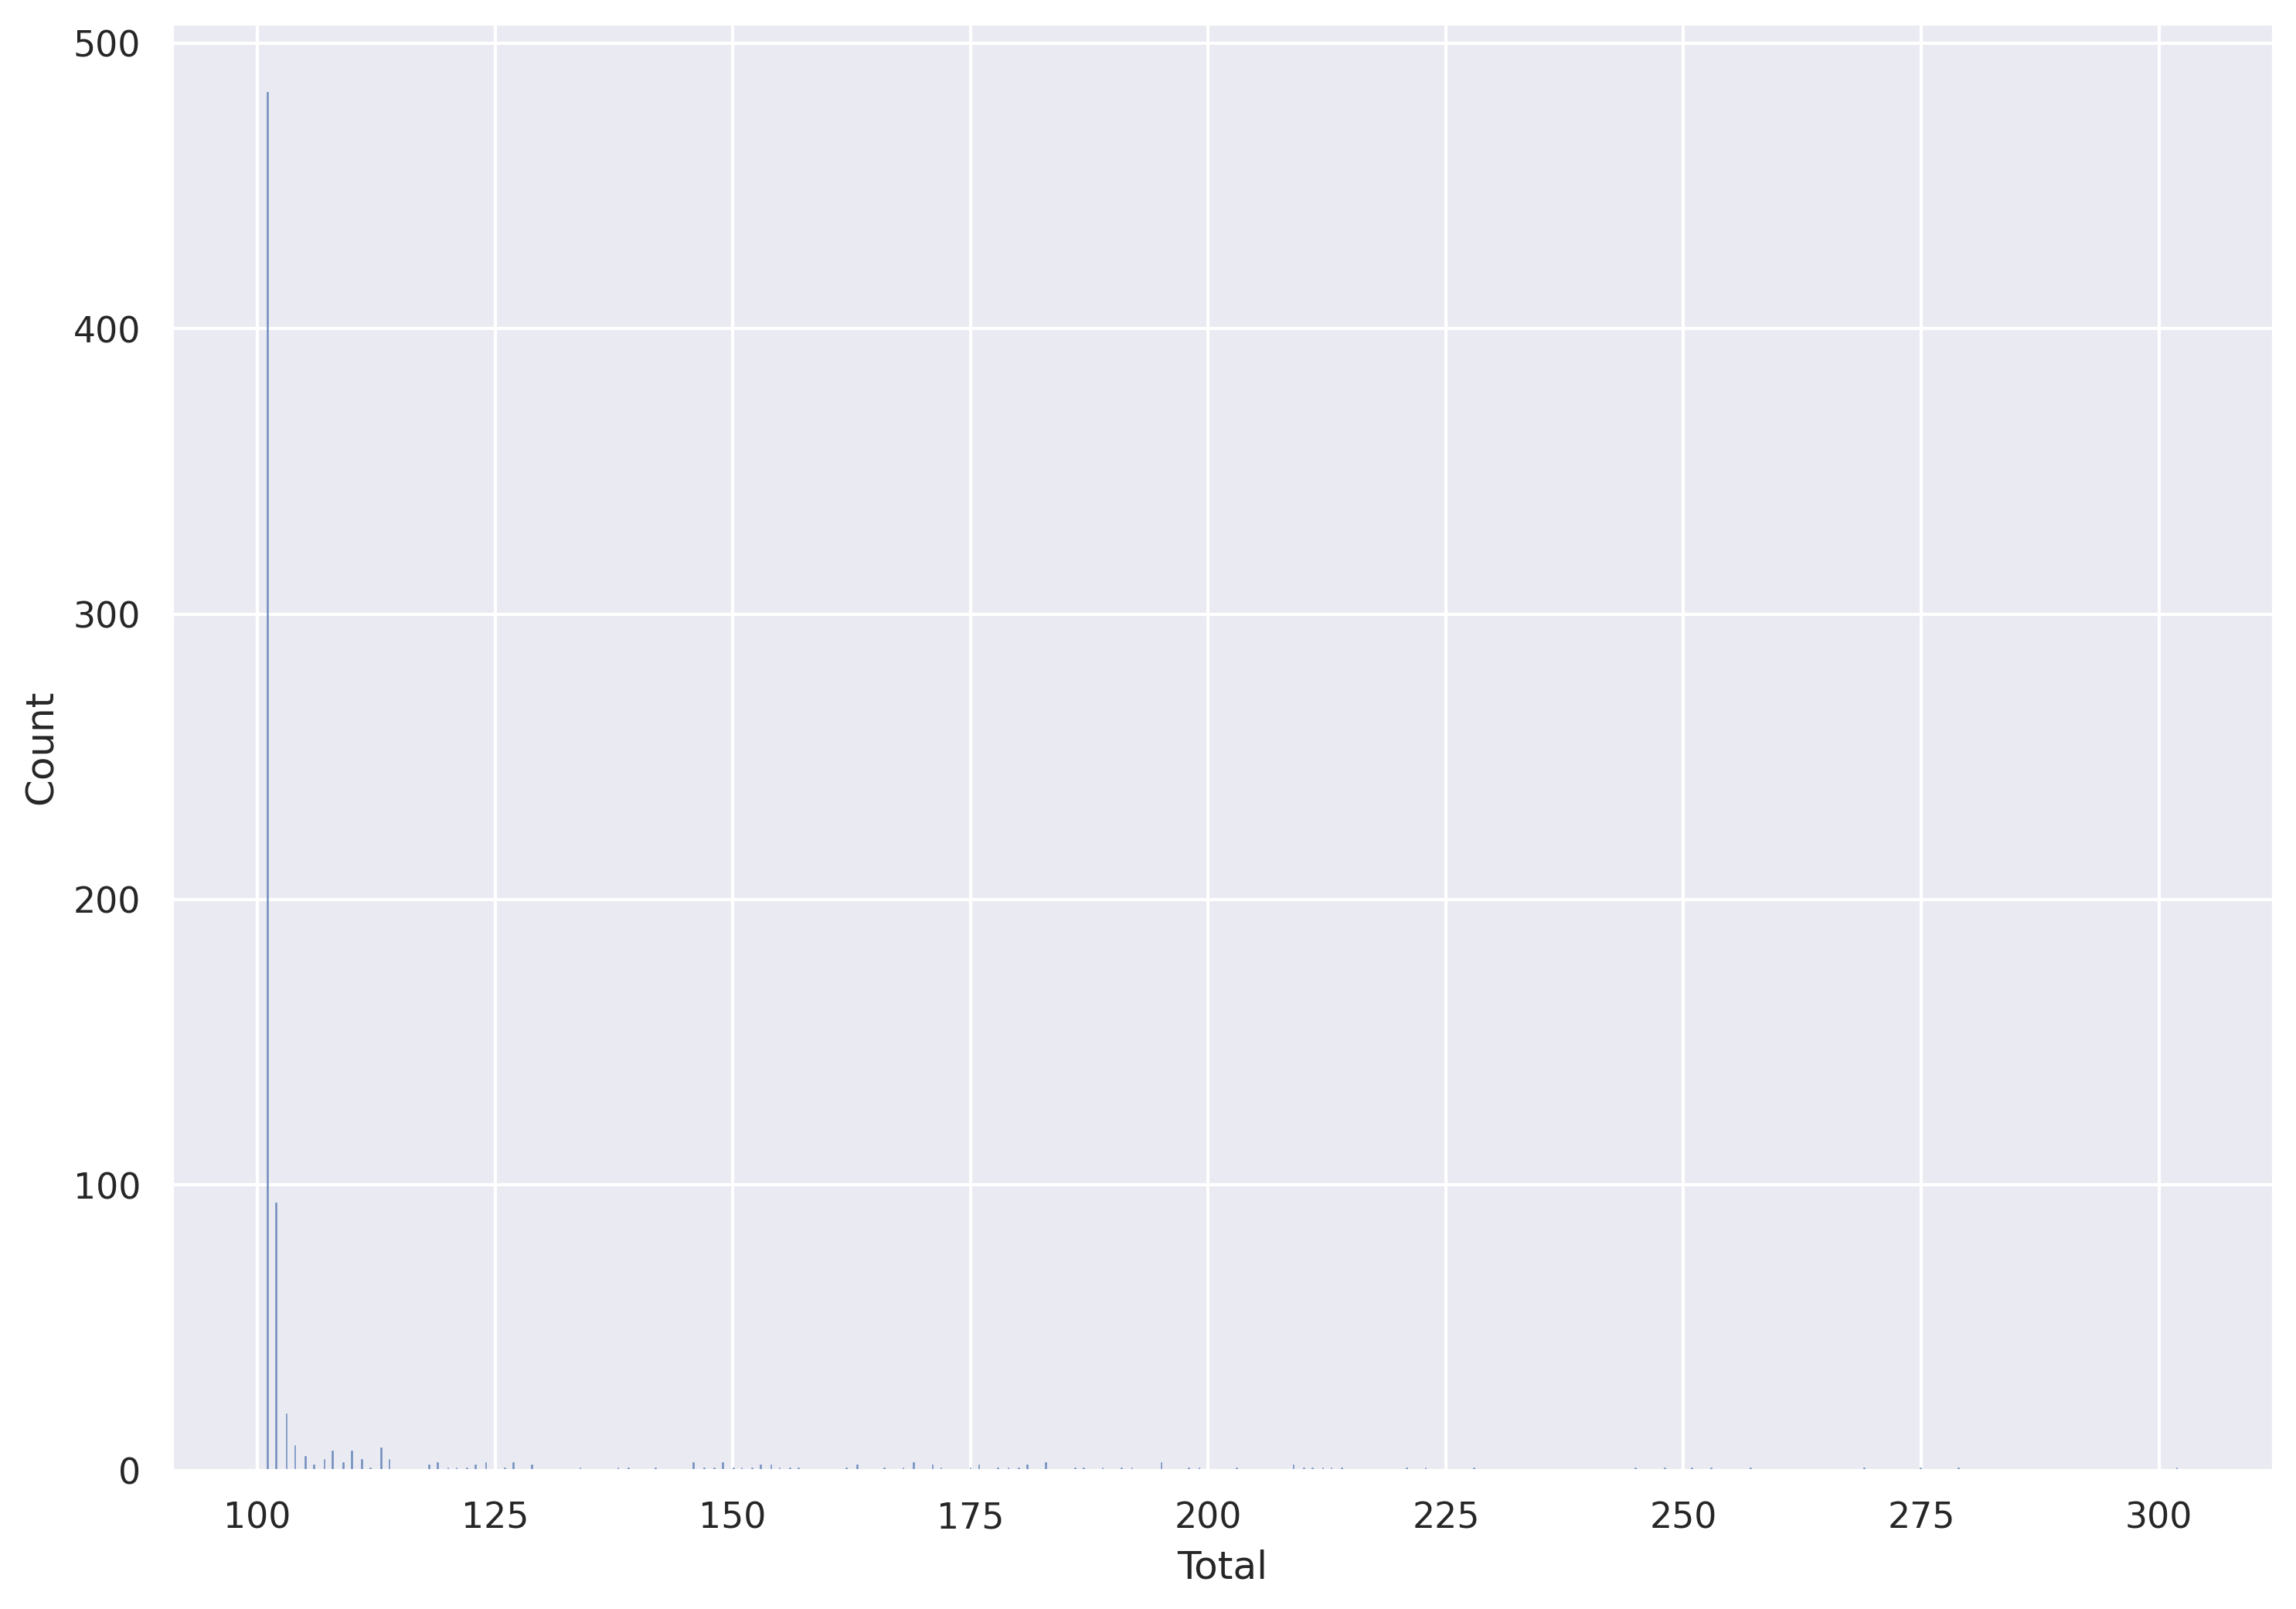

In [58]:
sns.histplot(ortho[ortho.Total > 100].Total)

In [118]:
ortho_bool = ortho.iloc[:, 1:-1].astype(bool).astype(int)
ortho_bool["amount"] = ortho_bool.sum(axis=1)
ortho_bool['Orthogroup'] = ortho['Orthogroup']

amount = [int(ortho_bool[ortho_bool.Orthogroup==i]['amount']) for i in events_frame.Name]
events_frame['amount'] = amount
total = [int(ortho[ortho.Orthogroup==i]['Total']) for i in events_frame.Name]
events_frame['total'] = total

(0.0, 200.0)

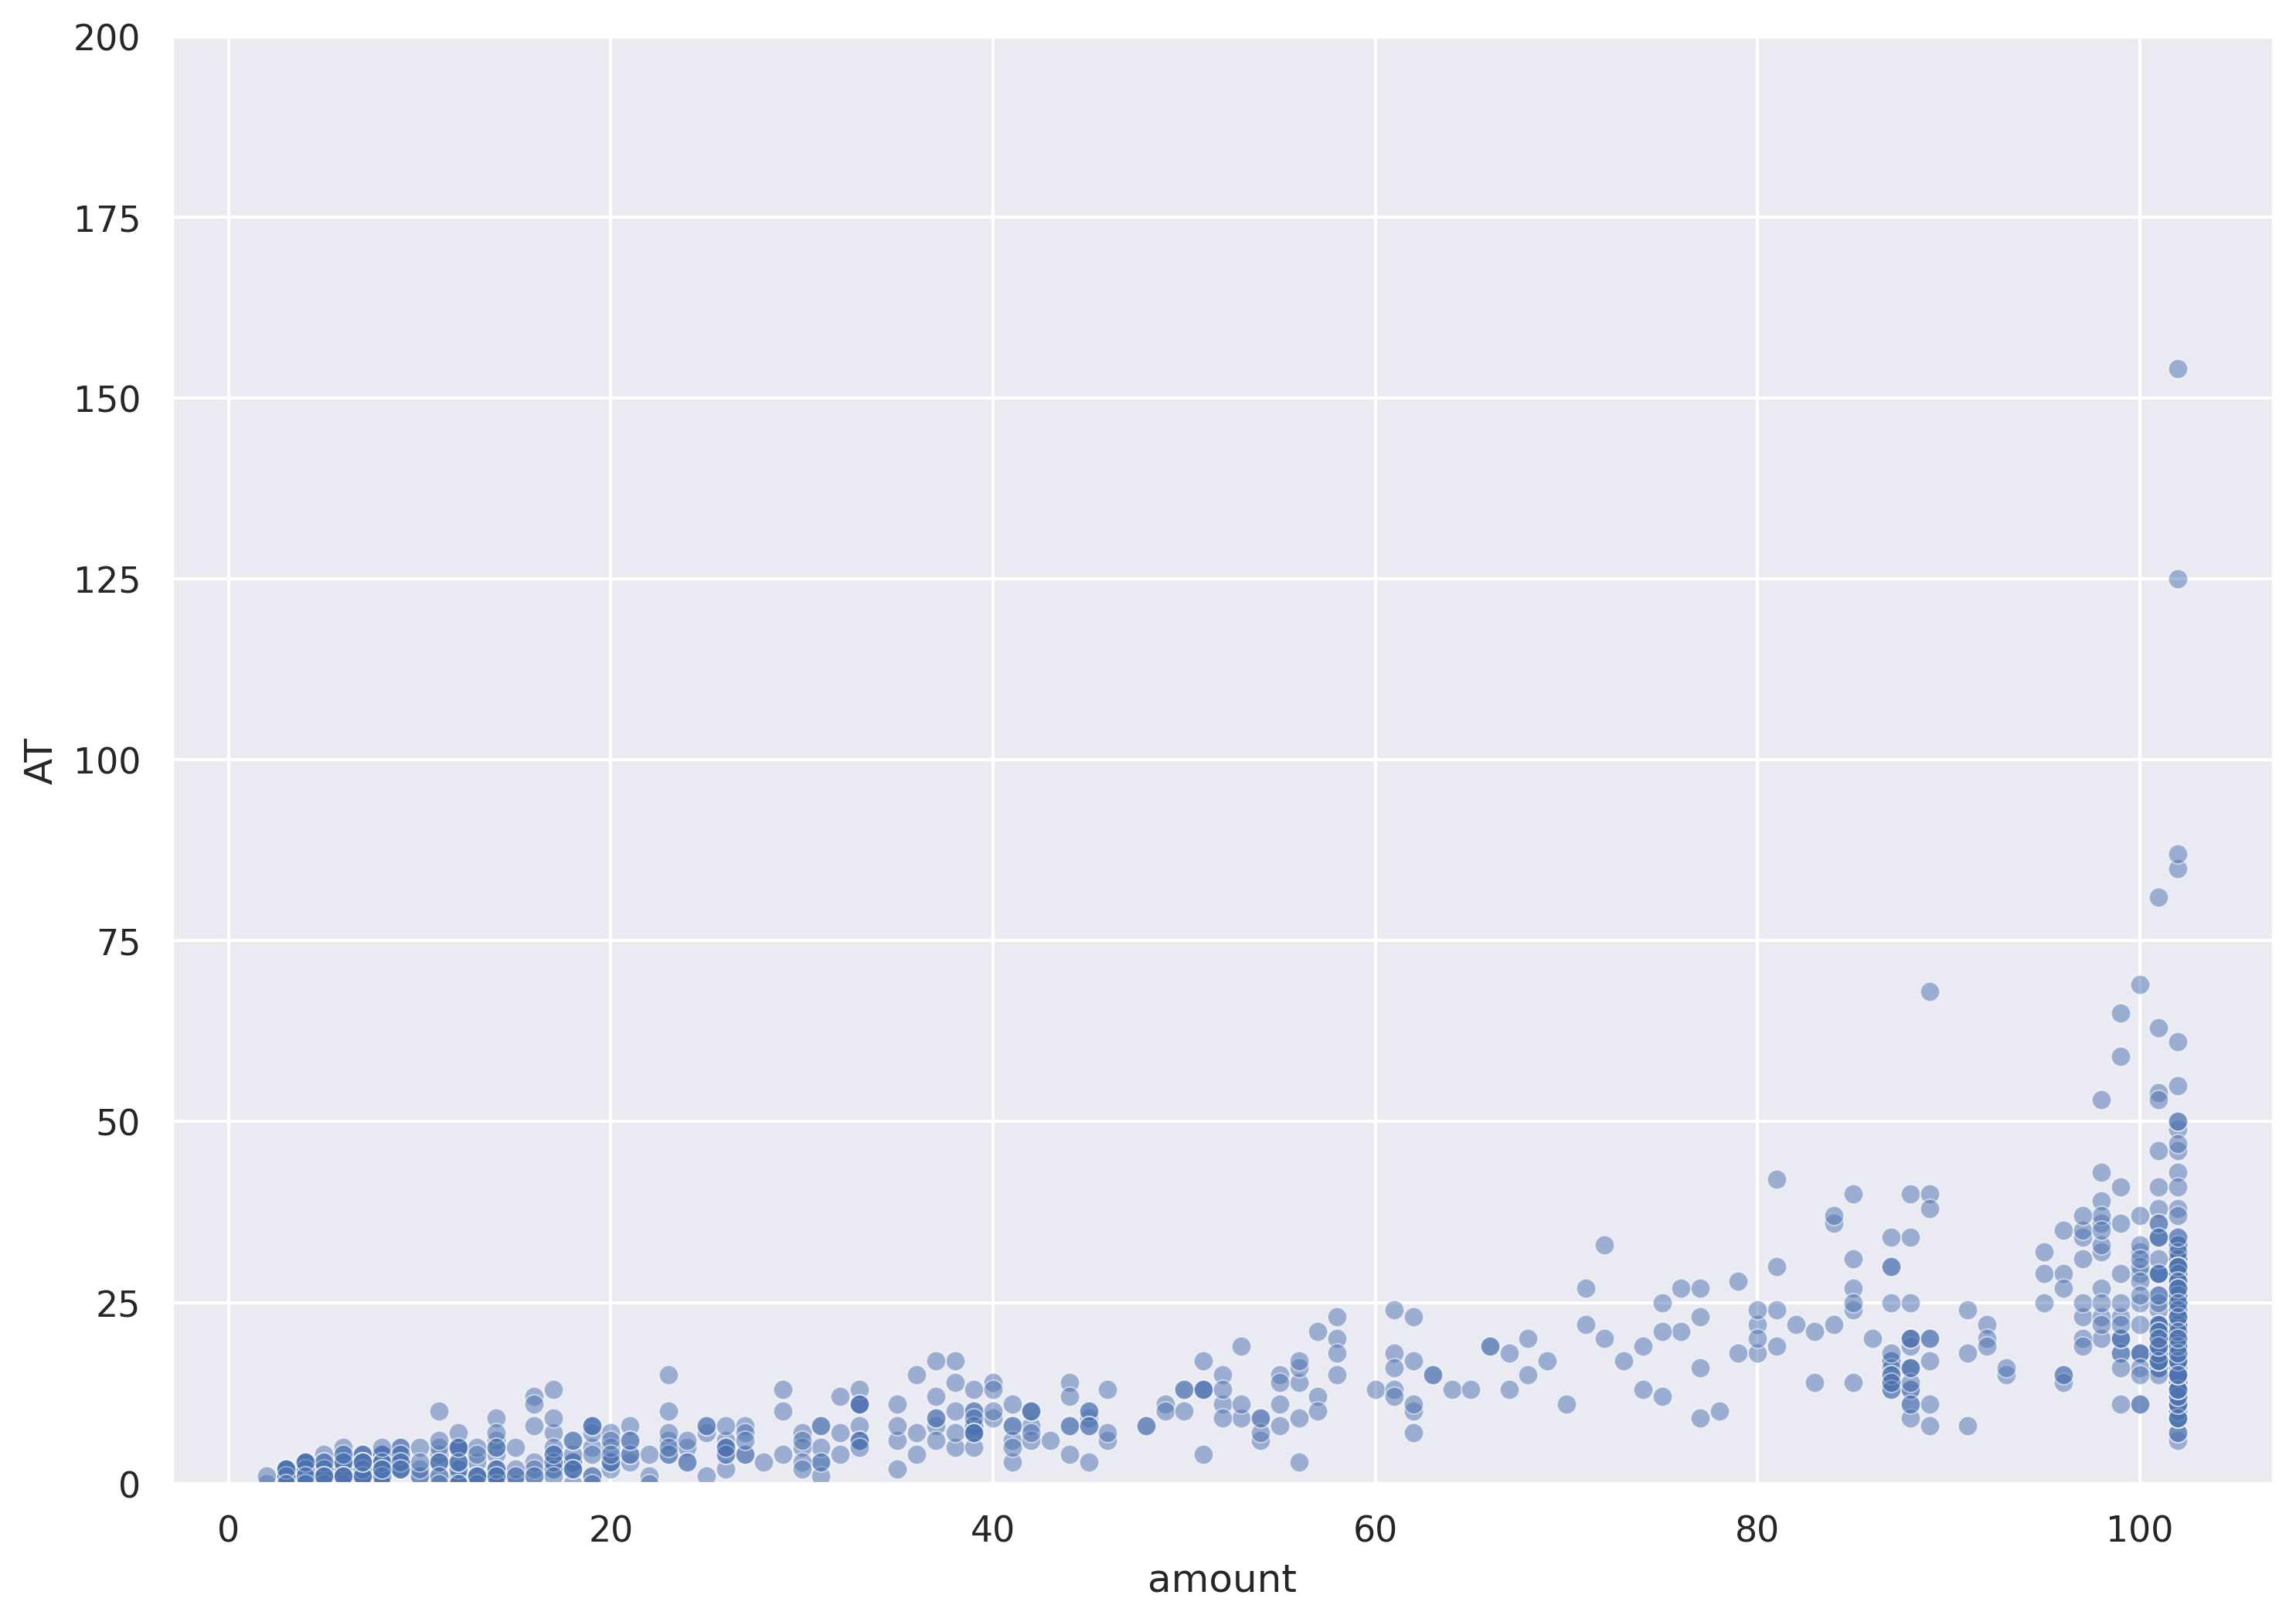

In [119]:
sns.scatterplot(x=events_frame.amount, y=events_frame.AT, alpha = 0.5)
plt.ylim([0,200])

<AxesSubplot:xlabel='amount', ylabel='Count'>

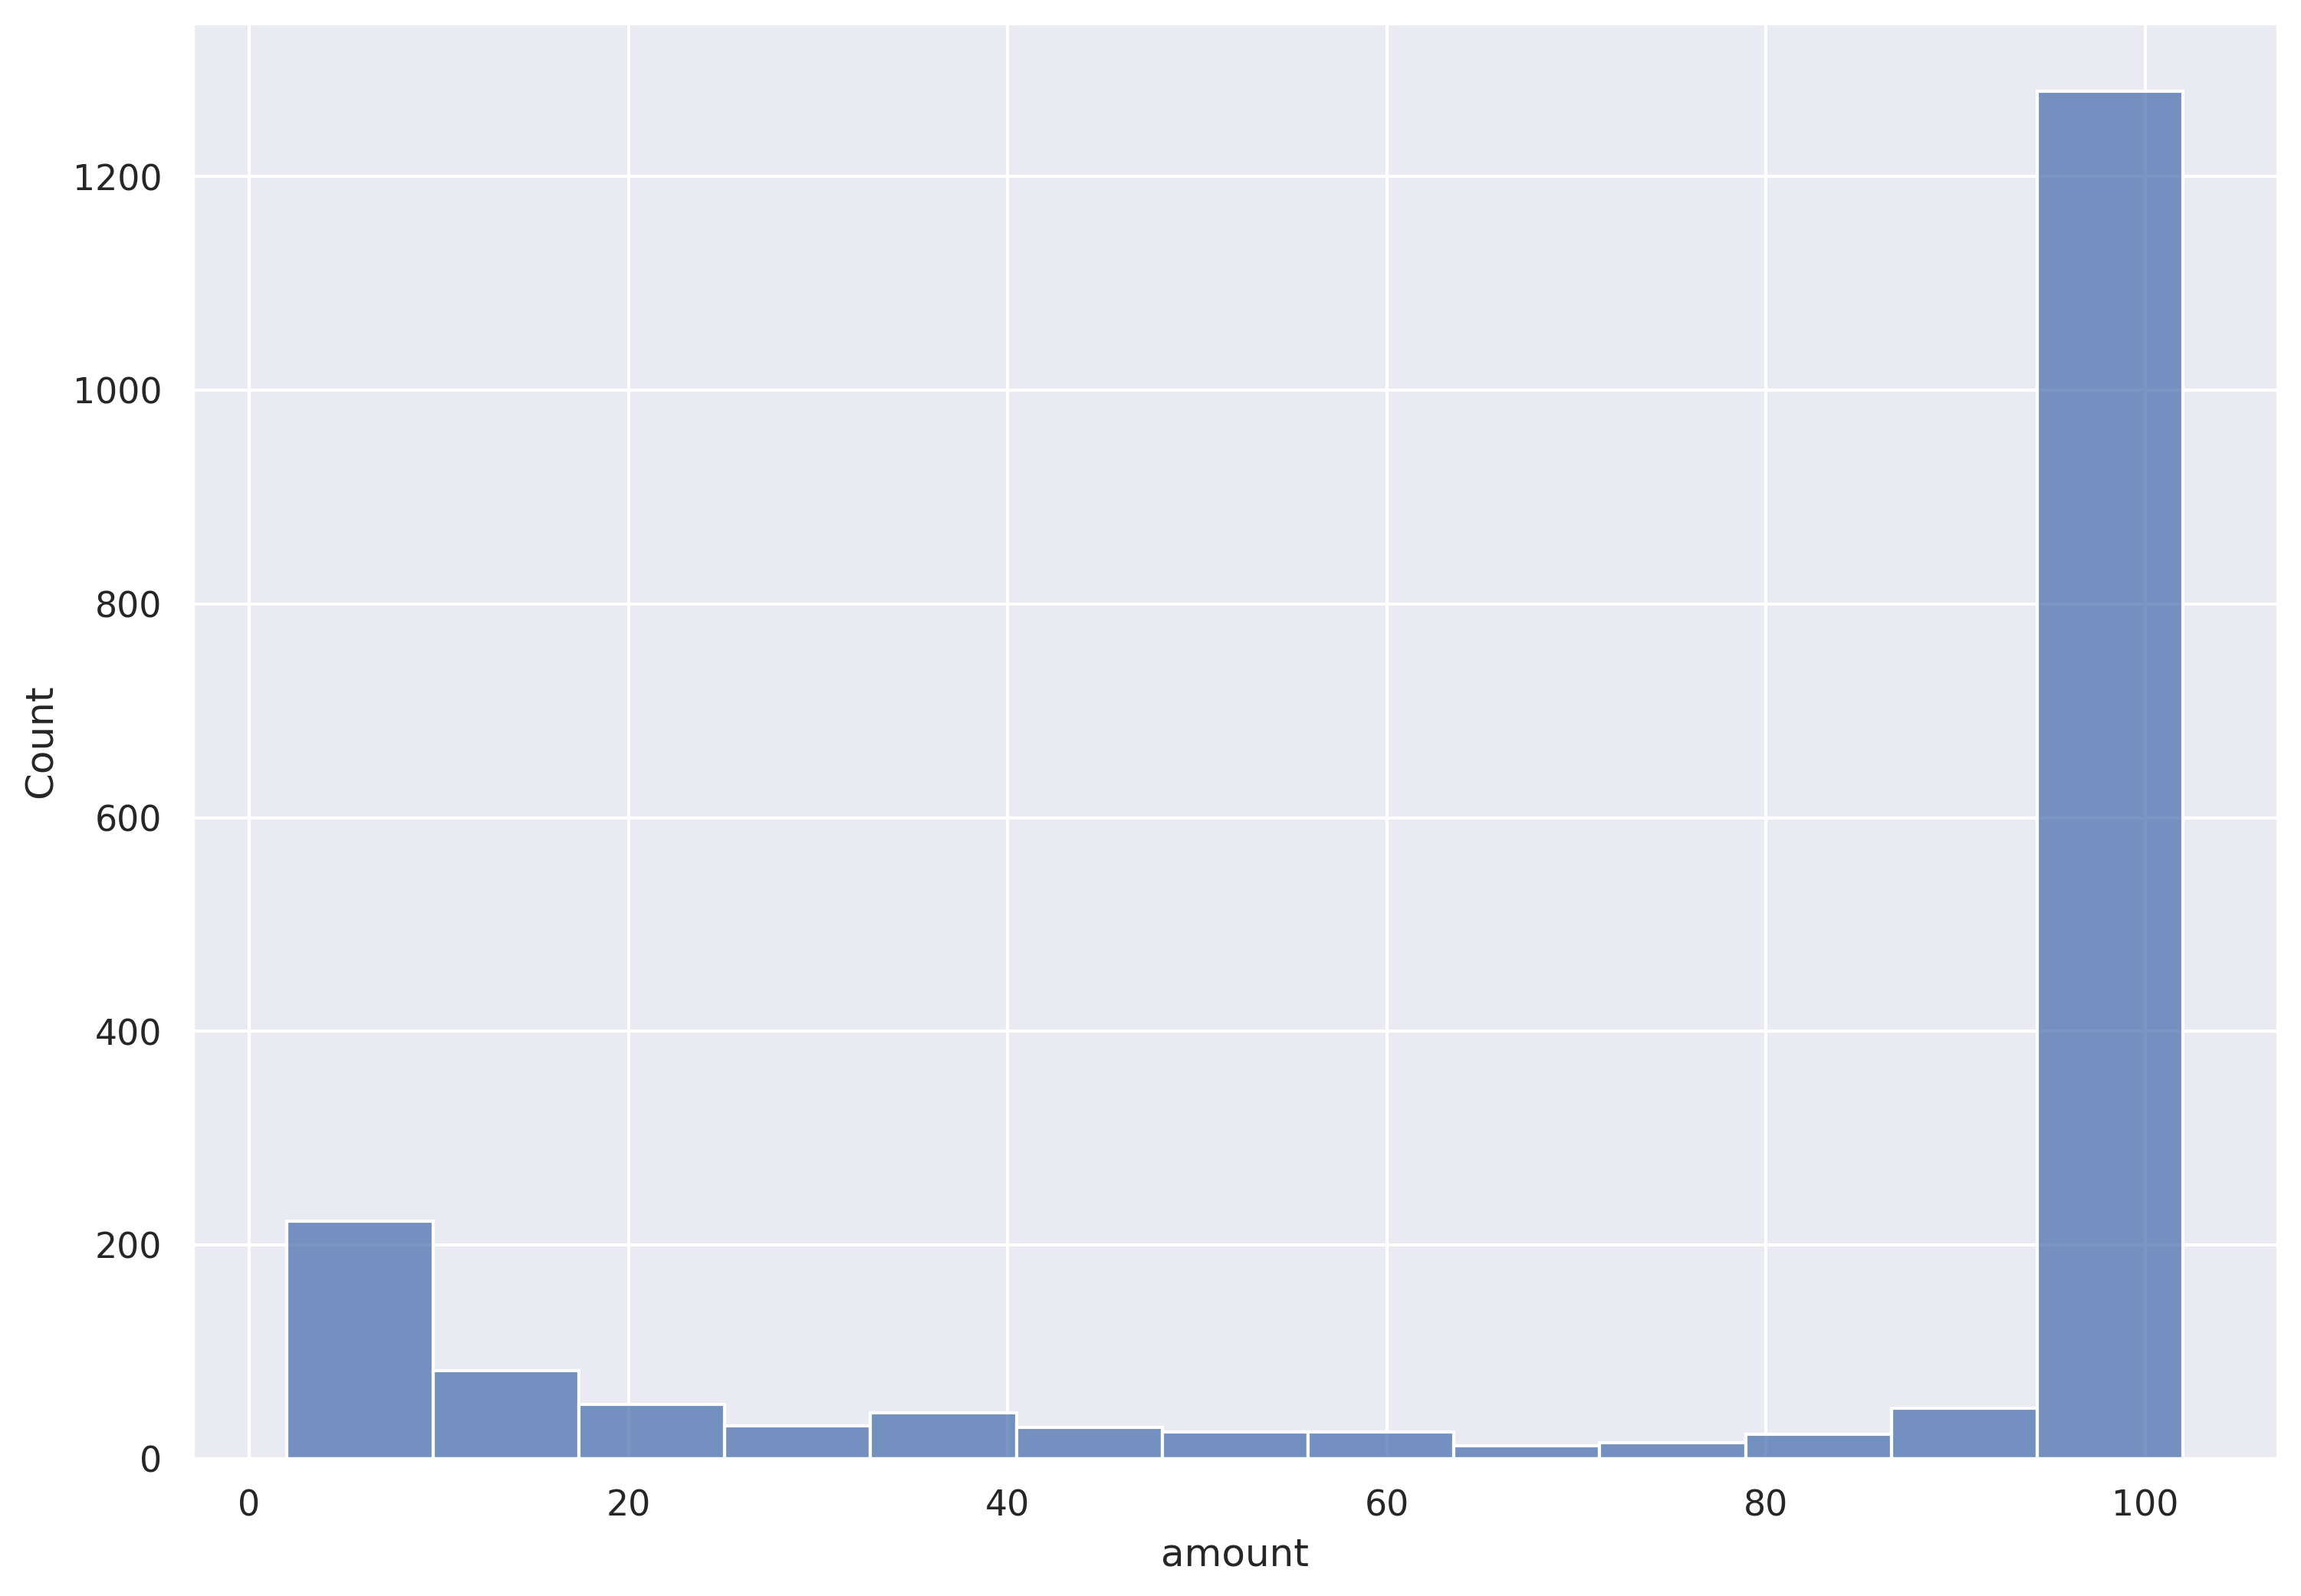

In [120]:
sns.histplot(events_frame.amount)

In [121]:
np.log([1, 2])

array([0.        , 0.69314718])

# See coordinate distribution of AT

In [122]:
refGen = "GCF_000333835.2_ASM33383v2_genomic"
ortho = pd.read_table('Results/Orthogroups.txt', sep = ':', header = None)
ortho = ortho.rename({0: 'og', 1: 'genes'}, axis='columns')


allTransfers = []
ogs = []
start_loc = []
end_loc = []
amount = []
total = []
genes_list = []
for og in events_frame.Name:
    genes = ortho[ortho.og == og]['genes'].values[0].split(' ')
    for gene in genes[1:]:
        if gene.split('|')[0] == refGen:
            allTransfers.append(int(events_frame[events_frame.Name == og]['AT']))
            ogs.append(og)
            start_loc.append(int(gene.split('|')[4]))
            end_loc.append(int(gene.split('|')[5]))
            genes_list.append(gene.split('|')[2])
            amount.append(int(events_frame[events_frame.Name == og]['amount']))
            total.append(int(events_frame[events_frame.Name == og]['total']))
loc_df = pd.DataFrame({'og':ogs, 'gene':genes_list, 'start_loc': start_loc, 'end_loc':end_loc, 'AT':allTransfers, 'amount':amount, 'total': total})

In [123]:
loc_df = loc_df.sort_values('start_loc')

<AxesSubplot:xlabel='AT', ylabel='Count'>

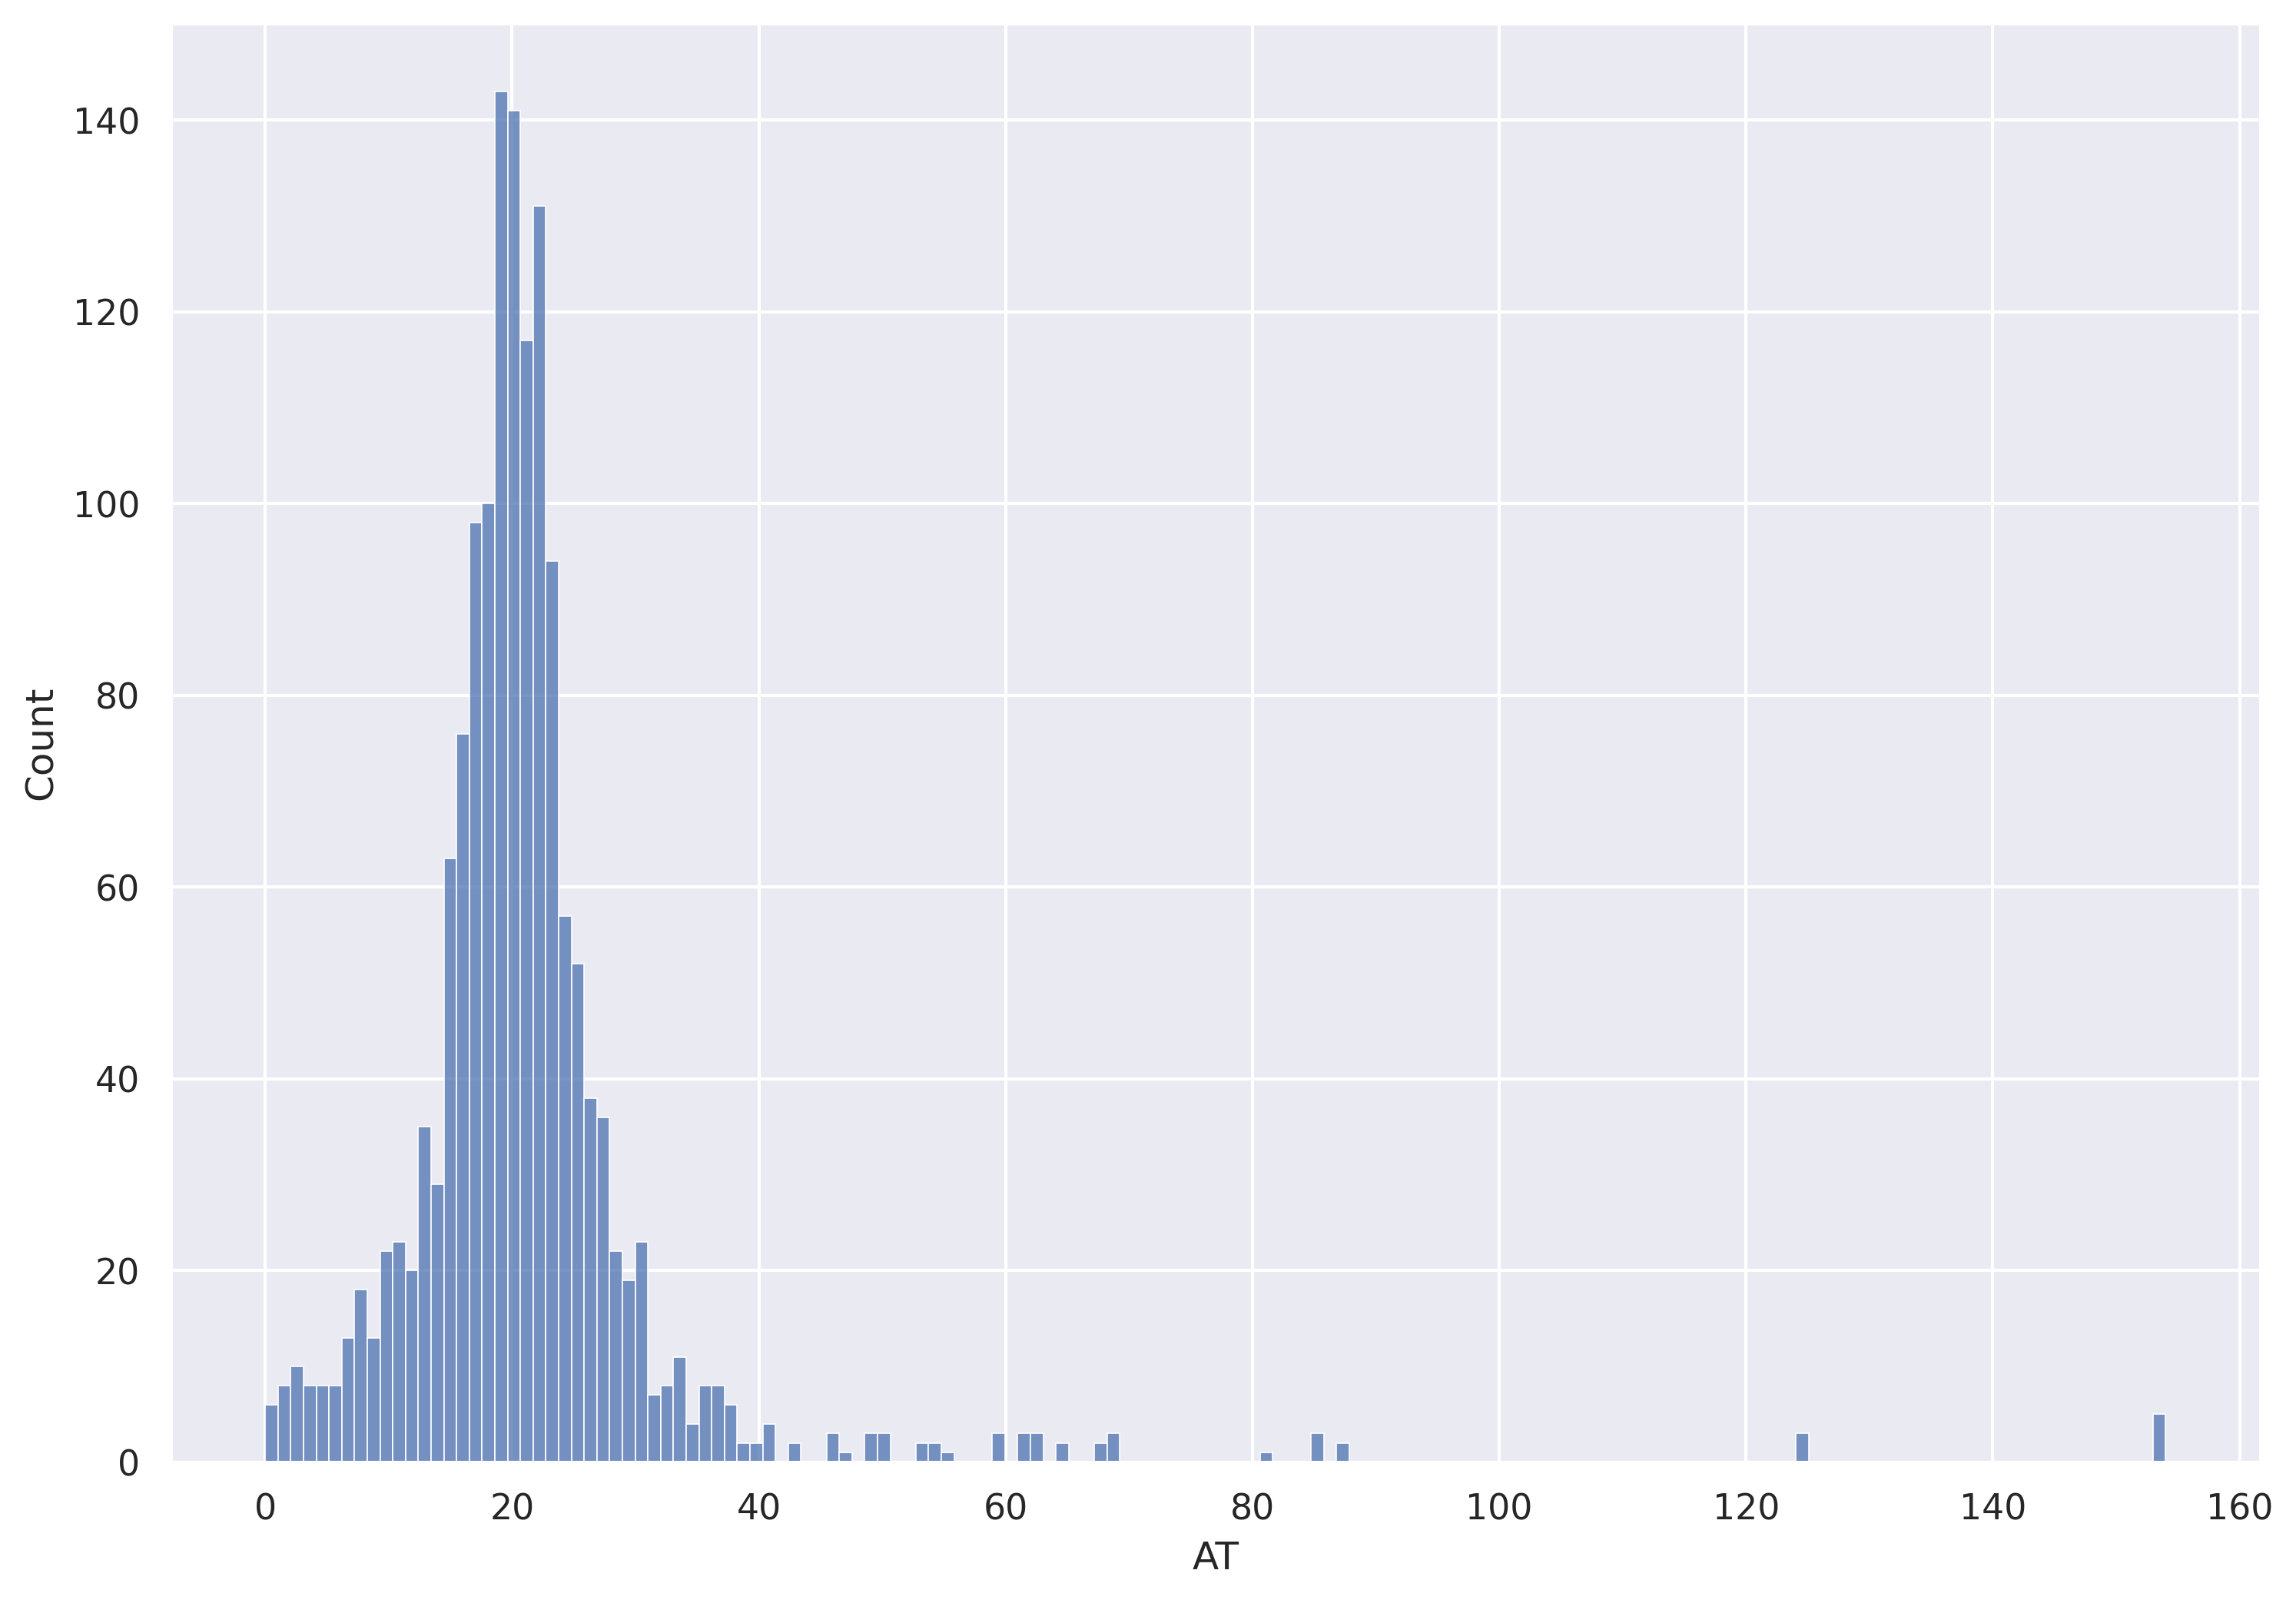

In [124]:
sns.histplot(x=loc_df.AT)

<AxesSubplot:xlabel='start_loc', ylabel='AT'>

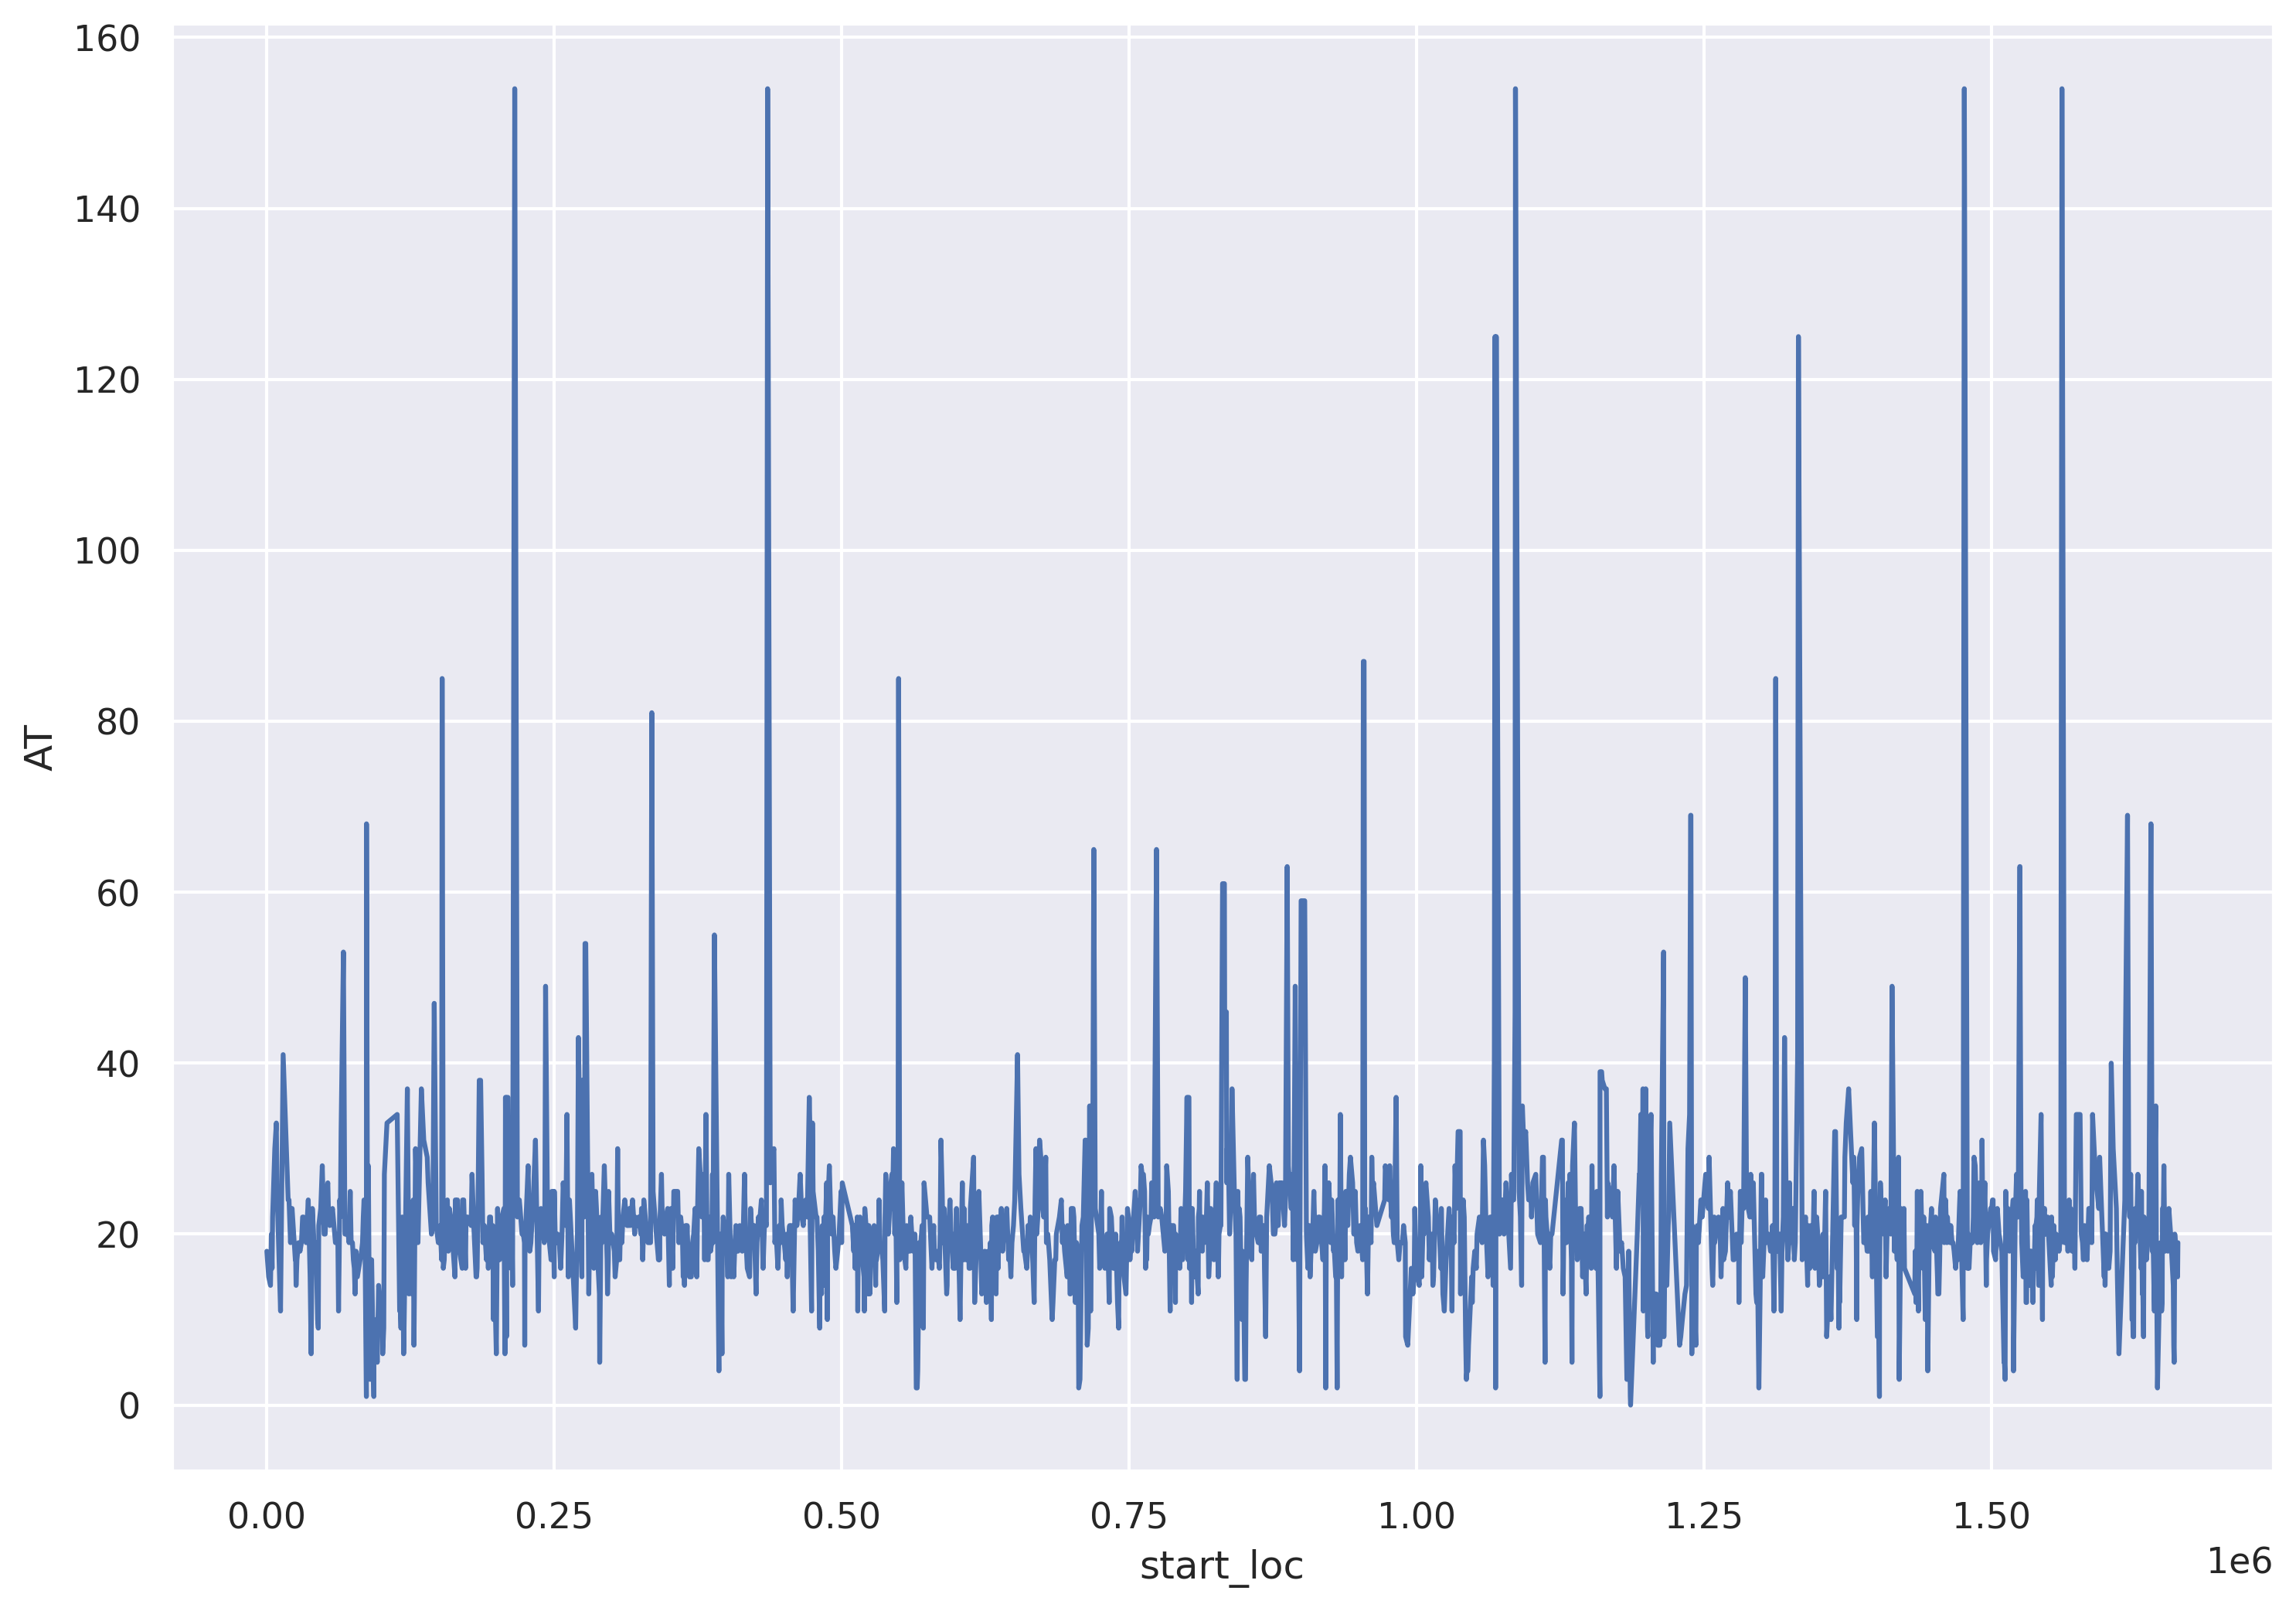

In [125]:
sns.lineplot(x=loc_df.start_loc, y=loc_df.AT)

<AxesSubplot:xlabel='start_loc'>

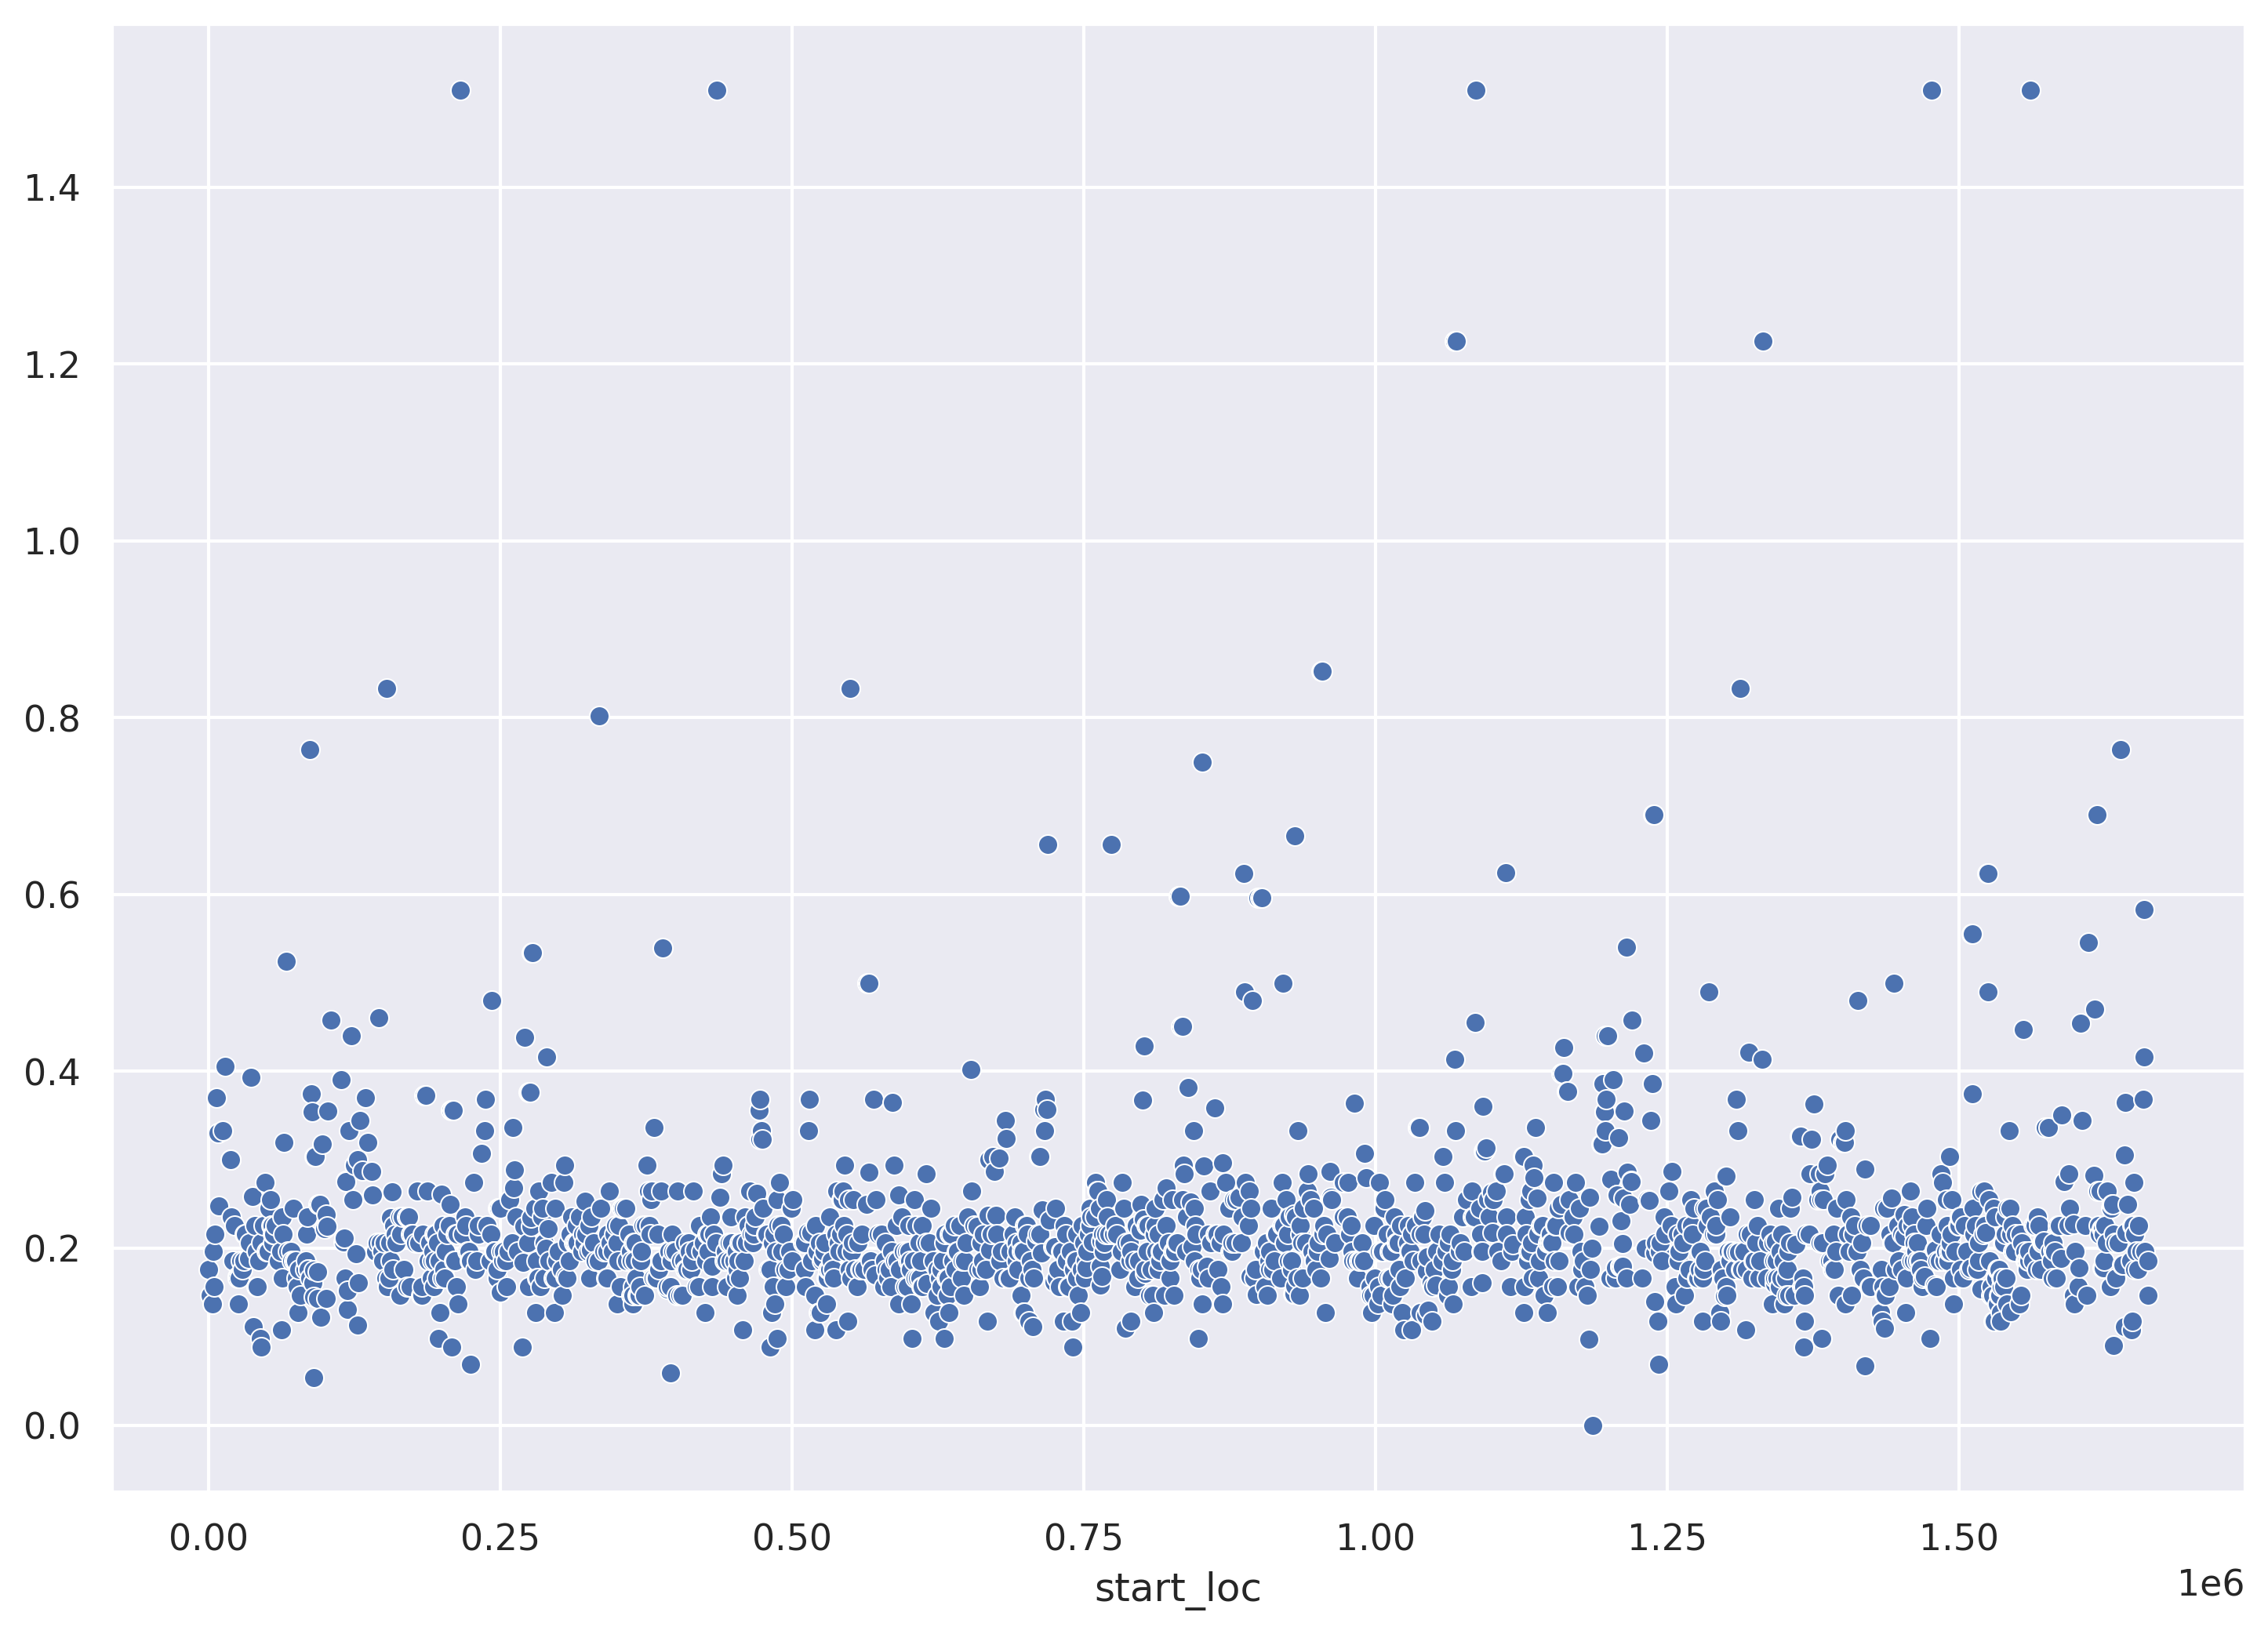

In [126]:
sns.scatterplot(x=loc_df.start_loc, y=loc_df.AT/loc_df.amount)

<AxesSubplot:xlabel='total', ylabel='AT'>

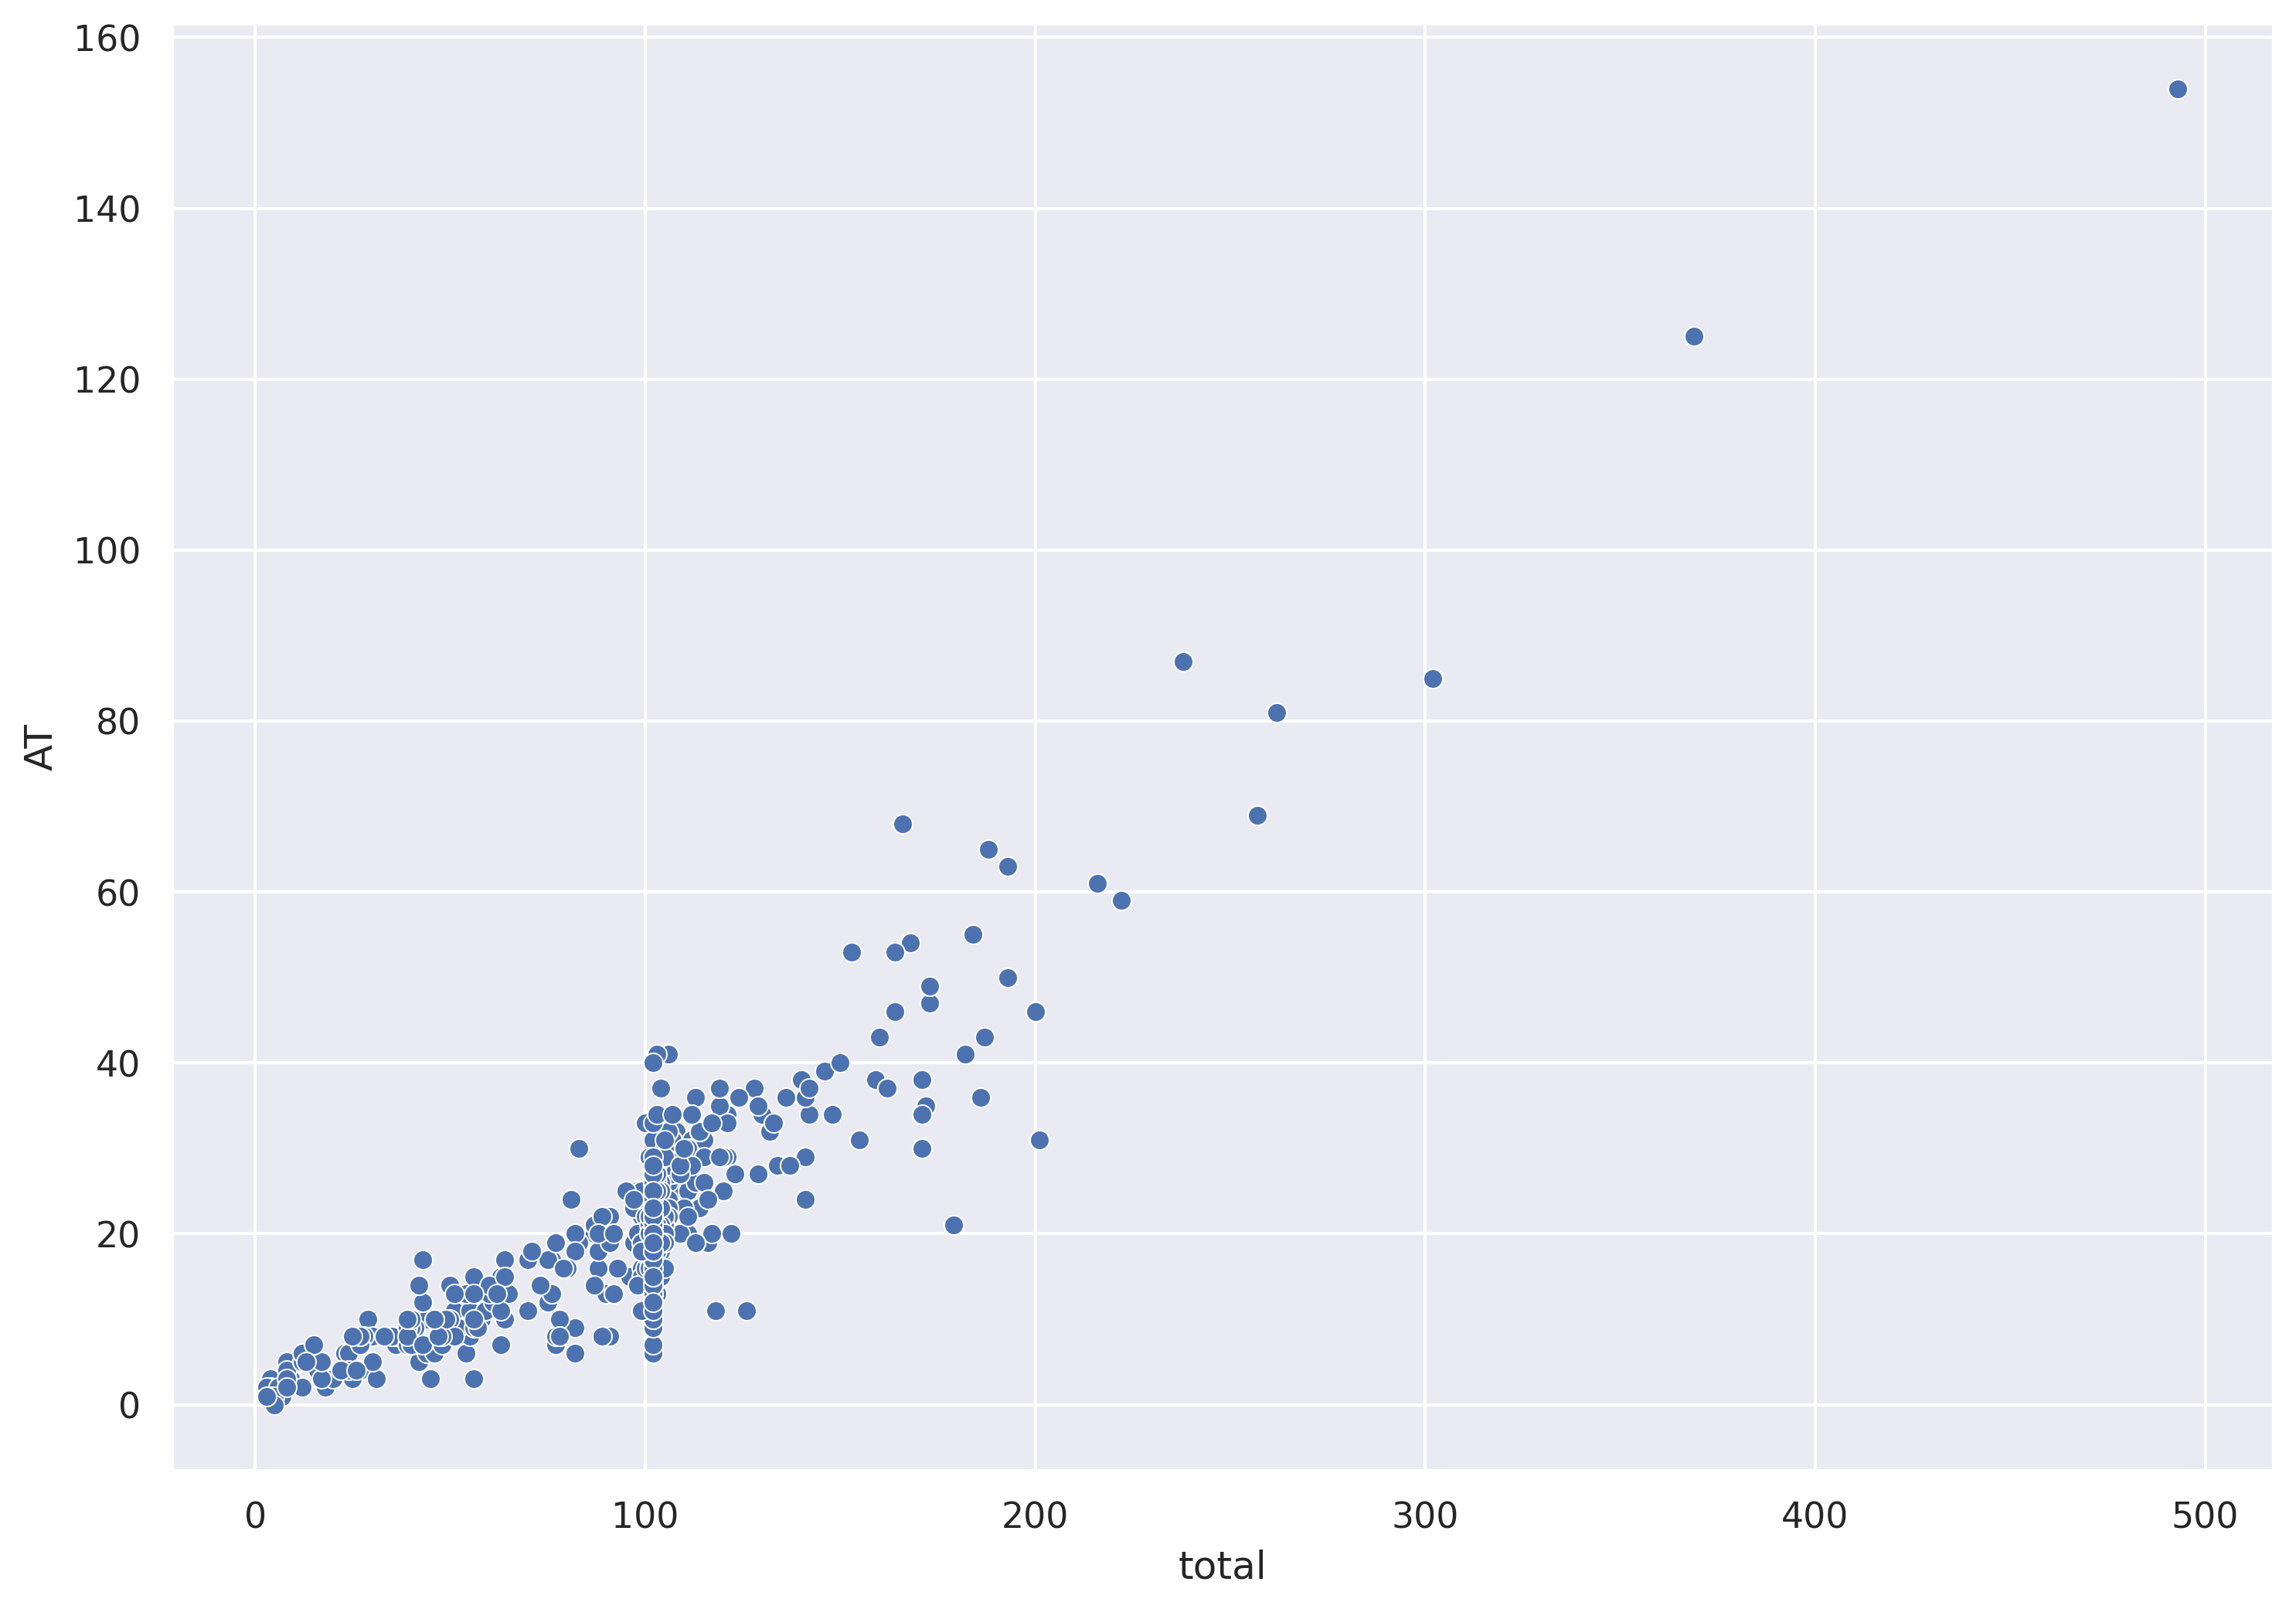

In [127]:
sns.scatterplot(x=loc_df.total, y=loc_df.AT)

# See recombinations

In [23]:
contig='UTI89'
refGen='GCF_000013265.1_ASM1326v1_genomic'

In [24]:
reads = pd.read_table('Results/{contig}.bed'.format(contig=contig), sep = '\t', header = None)

In [25]:
reads = reads.iloc[:, [1,2]]
reads = reads.rename({1: 'start', 2: 'end'}, axis='columns')

#add 1 to values because they are written from 0 in the bed file
reads.loc[:, 'start'] = reads['start'].apply(lambda x: x+1)
reads.loc[:, 'end'] = reads['end'].apply(lambda x: x+1)

In [26]:
depth_frame = pd.read_table('Results/depth{contig}.tsv'.format(contig=contig), sep = '\t', header = None)
depth_frame = depth_frame.rename({0: 'gene', 1: 'coordinate', 2: 'depth'}, axis='columns')

In [72]:
comp = pd.read_table('Results/gcb_res/{refGen}/window_complexity_contig_NC_007946.1.txt'.format(refGen=refGen, contig=contig), sep='\t')
comp['start'] = comp.position.apply(lambda x : x.split(':')[0])
comp['start'] = comp['start'].astype(float)
comp['end'] = comp.position.apply(lambda x : x.split(':')[1])
comp['end'] = comp['end'].astype(float)
comp = comp.drop('position', axis=1)
comp['complexity'] = comp['complexity'].astype(float)
comp = comp.sort_values('start')

In [ ]:
reads_max_end = int(reads['end'][-1:])
comp_max_end = int(comp['end'][-1:])
max_end = min(reads_max_end,comp_max_end)

In [28]:
score_list = []
GC_list = []
for index, row in comp.iterrows():
    start = int(row['start']) if int(row['start']) > 0 else 0
    end = int(row['end']) if int(row['end']) < max_end else max_end
    if end > max_end:
        break
    number = reads[(reads['start'] > start) & (reads['start'] <= end)].shape[0] + reads[(reads['end'] > start) & (reads['end'] <= end)].shape[0]
    depth = depth_frame[(depth_frame.coordinate > start) & (depth_frame.coordinate <= end)]['depth'].mean()
    score_list.append(number/depth)
    GC_list.append(GC(record.seq[start:end]))
comp = comp.iloc[0: min(len(comp), len(GC_list)), :]
comp['score'] = score_list
comp['GC'] = GC_list

<AxesSubplot:xlabel='start', ylabel='complexity'>

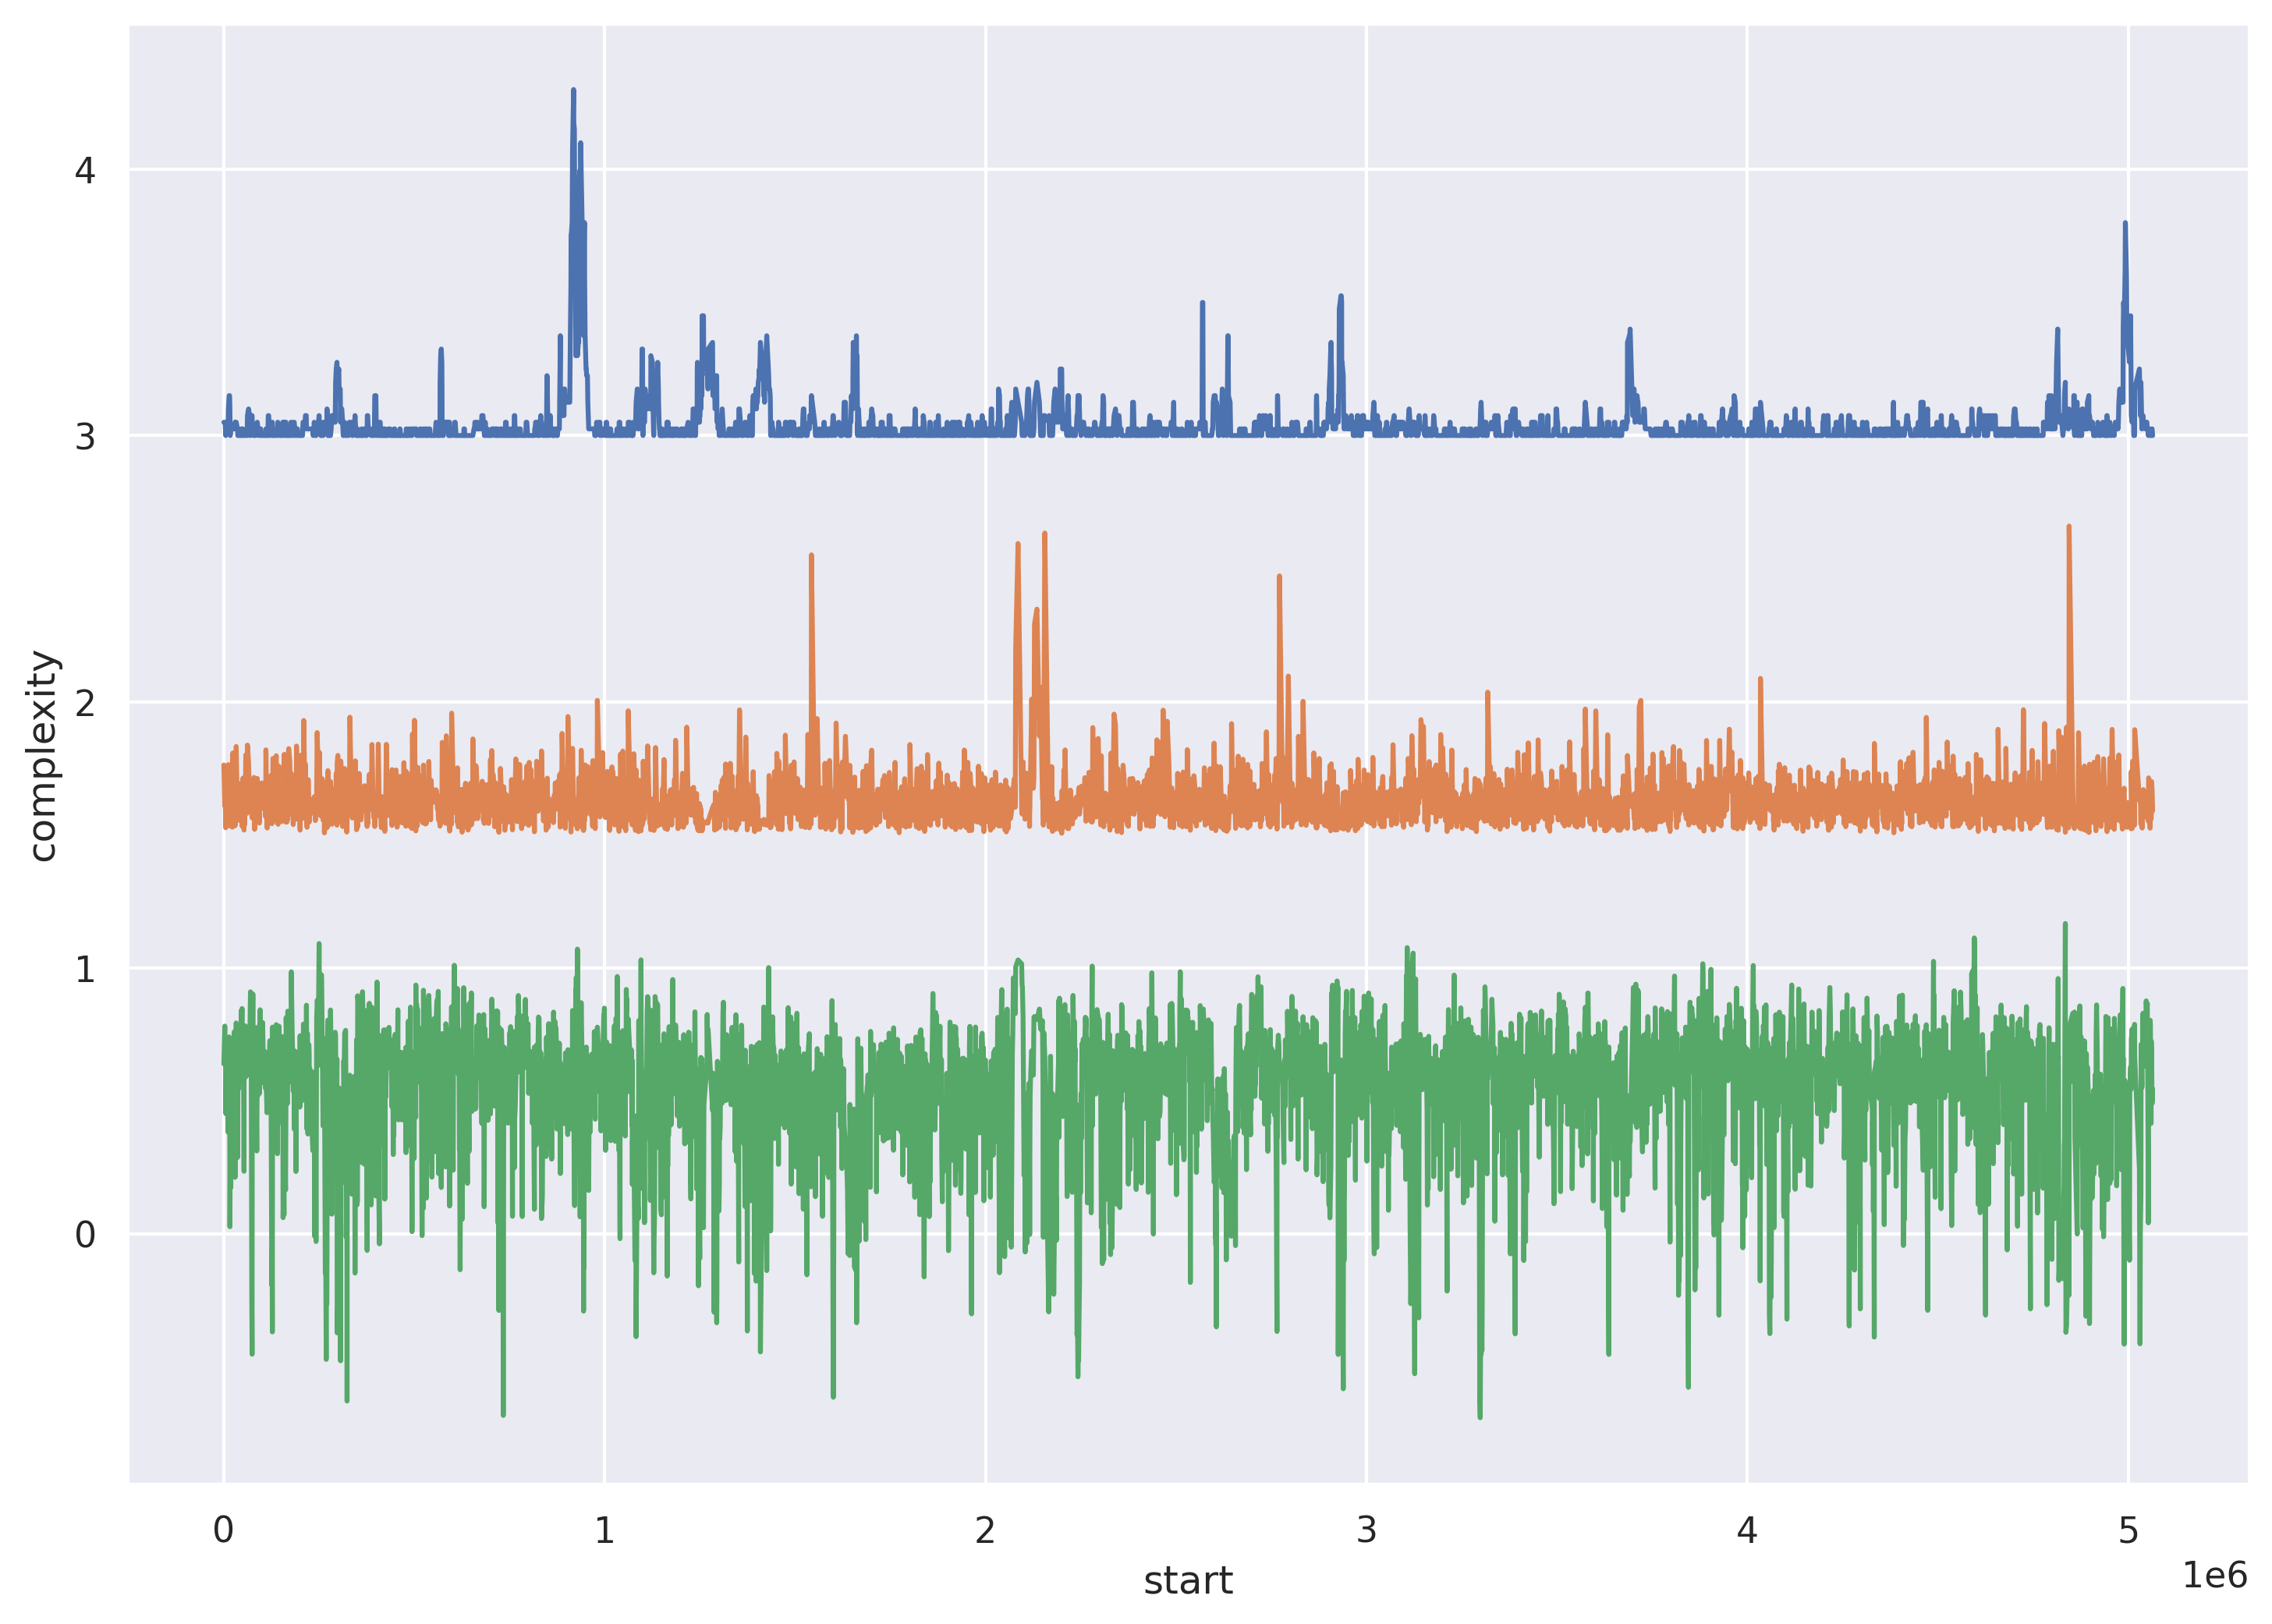

In [169]:
sns.lineplot(x=comp.start, y=comp.complexity + 3)
sns.lineplot(x=comp.start, y=comp.score*0.4 + 1.5)
sns.lineplot(x=comp.start, y=comp.GC*0.05 - 2)

In [170]:
comp.to_csv('Results/comp.csv')